#INI IMPORT LIBRARY

In [3]:
#import modul yang akan digunakan
import re
import string
import nltk

import pandas as pd
import numpy as np

from collections import Counter

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

#Scrap Data Dari GPlay

In [4]:
!pip install google-play-scraper

In [5]:
from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    'com.lazada.android',
    lang='id',
    sort=Sort.MOST_RELEVANT,
    count=3000,
    filter_score_with=None
)

In [6]:
df = pd.DataFrame(np.array(result), columns=['penilaian'])
df = df.join(pd.DataFrame(df.pop('penilaian'). tolist()))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,54a3f92a-aaf5-4f9d-8f2d-543bc52f9041,Nur hasanah Nara,https://play-lh.googleusercontent.com/a/ACg8oc...,Jujur saya lebih suka belanja disini tapi sete...,1,1380,7.36.0,2023-10-24 21:33:55,"Hi Kak Nur hasanah Nara, kami sampaikan permoh...",2023-10-24 21:45:51,7.36.0
1,9c0c72a9-6c88-4622-b475-7ffd6fa1a30d,Dessy Nurmiati,https://play-lh.googleusercontent.com/a-/ALV-U...,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,324,7.37.0,2023-10-29 10:09:38,"Hi Dessy Nurmiati, terima kasih untuk ulasan p...",2023-10-29 10:26:06,7.37.0
2,0d03f430-e6db-4599-8383-087feb6e82e5,Choirul Takdir Syahputra - Al-Ummiy,https://play-lh.googleusercontent.com/a/ACg8oc...,"Cepat dan baik. Latest problem: ""We have detec...",5,7122,7.34.0,2023-09-25 09:25:24,"Hi Kak Choirul Takdir Syahputra (C..., terima ...",2023-09-25 21:06:32,7.34.0
3,1fd77195-fe2c-4e70-b756-083b3b47af53,Sakura sweet,https://play-lh.googleusercontent.com/a-/ALV-U...,dulu iklan melulu sampai memenuhi layar dan me...,1,2470,7.35.1,2023-10-17 00:17:33,"Hi Kak Sakura sweet, kami sampaikan permohonan...",2023-10-17 00:26:01,7.35.1
4,1d91c361-d9fd-46b3-8c28-ca59bf1de45a,titan aulia,https://play-lh.googleusercontent.com/a-/ALV-U...,"aku pernah se jatuh cinta itu sama kamu, perna...",2,6626,7.34.0,2023-09-24 18:30:30,None,NaT,7.34.0


In [32]:
df[[ 'bintang', 'komentar']].head()

,bintang,komentar
0,1,Jujur saya lebih suka belanja disini tapi sete...
1,5,Dulu tiap ada voucer gratis ongkir bisa di gun...
2,5,"Cepat dan baik. Latest problem: ""We have detec..."
3,1,dulu iklan melulu sampai memenuhi layar dan me...
4,2,"aku pernah se jatuh cinta itu sama kamu, perna..."


In [33]:
df = df.rename(columns={ 'score': 'bintang', 'content': 'komentar'}) #ganti nama kolom

In [34]:
df[[ 'bintang', 'komentar']].head()

,bintang,komentar
0,1,Jujur saya lebih suka belanja disini tapi sete...
1,5,Dulu tiap ada voucer gratis ongkir bisa di gun...
2,5,"Cepat dan baik. Latest problem: ""We have detec..."
3,1,dulu iklan melulu sampai memenuhi layar dan me...
4,2,"aku pernah se jatuh cinta itu sama kamu, perna..."


In [17]:
len(df.index) #jumlah data dalam dataframe

3000

In [163]:
new_df = df[['bintang', 'komentar']]#DataFrame berisi bintang komen
sorted_df = new_df.sort_values(by='bintang', ascending=True) #DataFrame untuk diurutkan dari nilai terendah hingga tertinggi dalam kolom 'bintang'
sorted_df.head(3000)

,bintang,komentar
0,1,Jujur saya lebih suka belanja disini tapi sete...
1450,1,"Setiap buka aplikasi ini , lelet nya minta amp..."
1444,1,Begini ceritanya. Kalo pesen cod 3-4 hari samp...
1443,1,Ongkirnya mahal mahal banget harga barang yang...
1441,1,Kemarin pesan 2 barang karna wa ga aktif telfo...
...,...,...
271,5,"Selama belanja di lazada, jadi lebih mudah dan..."
997,5,Saya selalu dapat potongan harga yang gk masuk...
1989,5,"Trimakasih lazada,berkat adanya aplikasi lazad..."
266,5,dari sekian banyaknya produk yg dibeli sekitar...


In [36]:
df=df[['komentar', 'bintang']]

In [37]:
df.to_csv("data lazada.csv", index = False)

#Labeling

In [38]:
def labeling(bintang):
    if bintang < 3:
        return 'Negatif'
    elif bintang == 3:
        return 'Netral'
    elif bintang > 3:
        return 'Positif'

df['Klasifikasi'] = df['bintang'].apply(labeling)
print(df.head(3000))

                                               komentar  bintang Klasifikasi
0     Jujur saya lebih suka belanja disini tapi sete...        1     Negatif
1     Dulu tiap ada voucer gratis ongkir bisa di gun...        5     Positif
2     Cepat dan baik. Latest problem: "We have detec...        5     Positif
3     dulu iklan melulu sampai memenuhi layar dan me...        1     Negatif
4     aku pernah se jatuh cinta itu sama kamu, perna...        2     Negatif
...                                                 ...      ...         ...
2995  Apk nya mudah dioperasikan plus banyak diskonn...        5     Positif
2996  Kenapa Setelah Di update Aplikasi Lazada akhir...        2     Negatif
2997  saya suka belanja d lazada tp sekarang sekaran...        5     Positif
2998  sangat memuaskan harga juga terjangkau gratis ...        5     Positif
2999  Dulu sering belanja di lazada tapi skrang male...        1     Negatif

[3000 rows x 3 columns]


In [39]:
df.to_csv("data lazada.csv", index = False)

#Pre-processing

In [40]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/data lazada.csv')
df.head(3000)

,komentar,bintang,Klasifikasi
0,Jujur saya lebih suka belanja disini tapi sete...,1,Negatif
1,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,Positif
2,"Cepat dan baik. Latest problem: ""We have detec...",5,Positif
3,dulu iklan melulu sampai memenuhi layar dan me...,1,Negatif
4,"aku pernah se jatuh cinta itu sama kamu, perna...",2,Negatif
...,...,...,...
2995,Apk nya mudah dioperasikan plus banyak diskonn...,5,Positif
2996,Kenapa Setelah Di update Aplikasi Lazada akhir...,2,Negatif
2997,saya suka belanja d lazada tp sekarang sekaran...,5,Positif
2998,sangat memuaskan harga juga terjangkau gratis ...,5,Positif


#Deteksi Null

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   komentar     3000 non-null   object
 1   bintang      3000 non-null   int64 
 2   Klasifikasi  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB


#Data Cleaning

In [42]:
# read data file lazada.csv
df = pd.read_csv('/content/data lazada.csv')
print(df.head(3000))

                                               komentar  bintang Klasifikasi
0     Jujur saya lebih suka belanja disini tapi sete...        1     Negatif
1     Dulu tiap ada voucer gratis ongkir bisa di gun...        5     Positif
2     Cepat dan baik. Latest problem: "We have detec...        5     Positif
3     dulu iklan melulu sampai memenuhi layar dan me...        1     Negatif
4     aku pernah se jatuh cinta itu sama kamu, perna...        2     Negatif
...                                                 ...      ...         ...
2995  Apk nya mudah dioperasikan plus banyak diskonn...        5     Positif
2996  Kenapa Setelah Di update Aplikasi Lazada akhir...        2     Negatif
2997  saya suka belanja d lazada tp sekarang sekaran...        5     Positif
2998  sangat memuaskan harga juga terjangkau gratis ...        5     Positif
2999  Dulu sering belanja di lazada tapi skrang male...        1     Negatif

[3000 rows x 3 columns]


In [44]:
#cleaning data dari tanda dll
def clean_data(df, Text_Column, New_Text_Column_Name):
    df[New_Text_Column_Name] = df[Text_Column].apply(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x))

    df[New_Text_Column_Name] = df[New_Text_Column_Name].apply(lambda x: re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', x))

    df[New_Text_Column_Name] = df[New_Text_Column_Name].apply(lambda x: re.sub(r'[0-9]+','', x))

    df[New_Text_Column_Name] = df[New_Text_Column_Name].apply(lambda x: x.lower())

    return df

In [45]:
# read lazada.csv
df = pd.read_csv('/content/data lazada.csv')

# clean kolom 'komentar' dan simpan hasil kolom 'clean_data'
data_clean = clean_data(df, 'komentar', 'clean_data')

# tampilkan 3000 baris dari kolom 'clean_data'
print(data_clean['clean_data'].head(3000))

0       jujur saya lebih suka belanja disini tapi sete...
1       dulu tiap ada voucer gratis ongkir bisa di gun...
2       cepat dan baik  latest problem   we have detec...
3       dulu iklan melulu sampai memenuhi layar dan me...
4       aku pernah se jatuh cinta itu sama kamu  perna...
                              ...                        
2995    apk nya mudah dioperasikan plus banyak diskonn...
2996    kenapa setelah di update aplikasi lazada akhir...
2997    saya suka belanja d lazada tp sekarang sekaran...
2998    sangat memuaskan harga juga terjangkau gratis ...
2999    dulu sering belanja di lazada tapi skrang male...
Name: clean_data, Length: 3000, dtype: object


In [48]:
import nltk.corpus
nltk.download('stopwords')

from nltk.corpus import stopwords
stopword_ind = stopwords.words('indonesian')

data_clean['stopwords_content'] = data_clean['clean_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_ind)]))
data_clean.head(3000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,komentar,bintang,Klasifikasi,clean_data,stopwords_content
0,Jujur saya lebih suka belanja disini tapi sete...,1,Negatif,jujur saya lebih suka belanja disini tapi sete...,jujur suka belanja diperbarui males belanja ha...
1,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,Positif,dulu tiap ada voucer gratis ongkir bisa di gun...,voucer gratis ongkir gunain ga aktifitas akun ...
2,"Cepat dan baik. Latest problem: ""We have detec...",5,Positif,cepat dan baik latest problem we have detec...,cepat latest problem we have detected unusual ...
3,dulu iklan melulu sampai memenuhi layar dan me...,1,Negatif,dulu iklan melulu sampai memenuhi layar dan me...,iklan melulu memenuhi layar menggangu bs diski...
4,"aku pernah se jatuh cinta itu sama kamu, perna...",2,Negatif,aku pernah se jatuh cinta itu sama kamu perna...,jatuh cinta suka belanja menyenangkan belanja ...
...,...,...,...,...,...
2995,Apk nya mudah dioperasikan plus banyak diskonn...,5,Positif,apk nya mudah dioperasikan plus banyak diskonn...,apk nya mudah dioperasikan plus diskonnya sema...
2996,Kenapa Setelah Di update Aplikasi Lazada akhir...,2,Negatif,kenapa setelah di update aplikasi lazada akhir...,update aplikasi lazada eror sistem respon ya
2997,saya suka belanja d lazada tp sekarang sekaran...,5,Positif,saya suka belanja d lazada tp sekarang sekaran...,suka belanja d lazada tp kecewa karna tdk sesu...
2998,sangat memuaskan harga juga terjangkau gratis ...,5,Positif,sangat memuaskan harga juga terjangkau gratis ...,memuaskan harga terjangkau gratis ongkir promo


In [49]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['split_text'] = data_clean['stopwords_content'].apply(lambda x: word_tokenize(x))
data_clean.head(3000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,komentar,bintang,Klasifikasi,clean_data,stopwords_content,split_text
0,Jujur saya lebih suka belanja disini tapi sete...,1,Negatif,jujur saya lebih suka belanja disini tapi sete...,jujur suka belanja diperbarui males belanja ha...,"[jujur, suka, belanja, diperbarui, males, bela..."
1,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,Positif,dulu tiap ada voucer gratis ongkir bisa di gun...,voucer gratis ongkir gunain ga aktifitas akun ...,"[voucer, gratis, ongkir, gunain, ga, aktifitas..."
2,"Cepat dan baik. Latest problem: ""We have detec...",5,Positif,cepat dan baik latest problem we have detec...,cepat latest problem we have detected unusual ...,"[cepat, latest, problem, we, have, detected, u..."
3,dulu iklan melulu sampai memenuhi layar dan me...,1,Negatif,dulu iklan melulu sampai memenuhi layar dan me...,iklan melulu memenuhi layar menggangu bs diski...,"[iklan, melulu, memenuhi, layar, menggangu, bs..."
4,"aku pernah se jatuh cinta itu sama kamu, perna...",2,Negatif,aku pernah se jatuh cinta itu sama kamu perna...,jatuh cinta suka belanja menyenangkan belanja ...,"[jatuh, cinta, suka, belanja, menyenangkan, be..."
...,...,...,...,...,...,...
2995,Apk nya mudah dioperasikan plus banyak diskonn...,5,Positif,apk nya mudah dioperasikan plus banyak diskonn...,apk nya mudah dioperasikan plus diskonnya sema...,"[apk, nya, mudah, dioperasikan, plus, diskonny..."
2996,Kenapa Setelah Di update Aplikasi Lazada akhir...,2,Negatif,kenapa setelah di update aplikasi lazada akhir...,update aplikasi lazada eror sistem respon ya,"[update, aplikasi, lazada, eror, sistem, respo..."
2997,saya suka belanja d lazada tp sekarang sekaran...,5,Positif,saya suka belanja d lazada tp sekarang sekaran...,suka belanja d lazada tp kecewa karna tdk sesu...,"[suka, belanja, d, lazada, tp, kecewa, karna, ..."
2998,sangat memuaskan harga juga terjangkau gratis ...,5,Positif,sangat memuaskan harga juga terjangkau gratis ...,memuaskan harga terjangkau gratis ongkir promo,"[memuaskan, harga, terjangkau, gratis, ongkir,..."


In [50]:
data_clean.head(3000)

,komentar,bintang,Klasifikasi,clean_data,stopwords_content,split_text
0,Jujur saya lebih suka belanja disini tapi sete...,1,Negatif,jujur saya lebih suka belanja disini tapi sete...,jujur suka belanja diperbarui males belanja ha...,"[jujur, suka, belanja, diperbarui, males, bela..."
1,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,Positif,dulu tiap ada voucer gratis ongkir bisa di gun...,voucer gratis ongkir gunain ga aktifitas akun ...,"[voucer, gratis, ongkir, gunain, ga, aktifitas..."
2,"Cepat dan baik. Latest problem: ""We have detec...",5,Positif,cepat dan baik latest problem we have detec...,cepat latest problem we have detected unusual ...,"[cepat, latest, problem, we, have, detected, u..."
3,dulu iklan melulu sampai memenuhi layar dan me...,1,Negatif,dulu iklan melulu sampai memenuhi layar dan me...,iklan melulu memenuhi layar menggangu bs diski...,"[iklan, melulu, memenuhi, layar, menggangu, bs..."
4,"aku pernah se jatuh cinta itu sama kamu, perna...",2,Negatif,aku pernah se jatuh cinta itu sama kamu perna...,jatuh cinta suka belanja menyenangkan belanja ...,"[jatuh, cinta, suka, belanja, menyenangkan, be..."
...,...,...,...,...,...,...
2995,Apk nya mudah dioperasikan plus banyak diskonn...,5,Positif,apk nya mudah dioperasikan plus banyak diskonn...,apk nya mudah dioperasikan plus diskonnya sema...,"[apk, nya, mudah, dioperasikan, plus, diskonny..."
2996,Kenapa Setelah Di update Aplikasi Lazada akhir...,2,Negatif,kenapa setelah di update aplikasi lazada akhir...,update aplikasi lazada eror sistem respon ya,"[update, aplikasi, lazada, eror, sistem, respo..."
2997,saya suka belanja d lazada tp sekarang sekaran...,5,Positif,saya suka belanja d lazada tp sekarang sekaran...,suka belanja d lazada tp kecewa karna tdk sesu...,"[suka, belanja, d, lazada, tp, kecewa, karna, ..."
2998,sangat memuaskan harga juga terjangkau gratis ...,5,Positif,sangat memuaskan harga juga terjangkau gratis ...,memuaskan harga terjangkau gratis ongkir promo,"[memuaskan, harga, terjangkau, gratis, ongkir,..."


#Data Stem

In [51]:
!pip install Sastrawi #stemming dengan library Sastrawi untuk pemrosesan teks bahasa indonesia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [55]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [54]:
def stemming(term):
  return stemmer.stem(term)

td = {}
jml = 0

for document in data_clean['split_text']:
  for term in document:
    if term not in td:
      td[term] = ' '

print(len(td))
print("======================")
for term in td:
  td[term] = stemming(term)
  jml+=1
  print(jml,":",term,":" ,td[term])

print(td)
print("======================")

def get_stemmed_term(document):
  return [td[term] for term in document]

data_clean['text_steamindo'] = data_clean['split_text'].apply(lambda x:' '.join(get_stemmed_term(x)))
data_clean.head(3000)

Output streaming akan dipotong hingga 5000 baris terakhir.
1056 : tgl : tgl
1057 : japo : japo
1058 : bank : bank
1059 : memperbaiki : baik
1060 : tf : tf
1061 : bunga : bunga
1062 : total : total
1063 : lakukan : laku
1064 : bodong : bodong
1065 : verifikasi : verifikasi
1066 : return : return
1067 : mengajukan : aju
1068 : terealisasi : realisasi
1069 : tim : tim
1070 : itikad : itikad
1071 : diselesaikan : selesai
1072 : viral : viral
1073 : medsos : medsos
1074 : relevan : relevan
1075 : kadaluarsa : kadaluarsa
1076 : setahun : tahun
1077 : donwload : donwload
1078 : kenaikan : naik
1079 : mengurangi : kurang
1080 : kenyamanan : nyaman
1081 : makai : maka
1082 : melebihi : lebih
1083 : ekstimasi : ekstimasi
1084 : estimasi : estimasi
1085 : dikirimnya : kirim
1086 : besok : besok
1087 : akuratkan : akurat
1088 : bangetttttt : bangetttttt
1089 : ma : ma
1090 : memuaskan : muas
1091 : sungguh : sungguh
1092 : terpercaya : percaya
1093 : berkwalitas : berkwalitas
1094 : ekonomis : eko

,komentar,bintang,Klasifikasi,clean_data,stopwords_content,split_text,text_steamindo
0,Jujur saya lebih suka belanja disini tapi sete...,1,Negatif,jujur saya lebih suka belanja disini tapi sete...,jujur suka belanja diperbarui males belanja ha...,"[jujur, suka, belanja, diperbarui, males, bela...",jujur suka belanja baru males belanja harga te...
1,Dulu tiap ada voucer gratis ongkir bisa di gun...,5,Positif,dulu tiap ada voucer gratis ongkir bisa di gun...,voucer gratis ongkir gunain ga aktifitas akun ...,"[voucer, gratis, ongkir, gunain, ga, aktifitas...",voucer gratis ongkir gunain ga aktifitas akun ...
2,"Cepat dan baik. Latest problem: ""We have detec...",5,Positif,cepat dan baik latest problem we have detec...,cepat latest problem we have detected unusual ...,"[cepat, latest, problem, we, have, detected, u...",cepat latest problem we have detected unusual ...
3,dulu iklan melulu sampai memenuhi layar dan me...,1,Negatif,dulu iklan melulu sampai memenuhi layar dan me...,iklan melulu memenuhi layar menggangu bs diski...,"[iklan, melulu, memenuhi, layar, menggangu, bs...",iklan melulu penuh layar menggangu bs skip buk...
4,"aku pernah se jatuh cinta itu sama kamu, perna...",2,Negatif,aku pernah se jatuh cinta itu sama kamu perna...,jatuh cinta suka belanja menyenangkan belanja ...,"[jatuh, cinta, suka, belanja, menyenangkan, be...",jatuh cinta suka belanja senang belanja diskon...
...,...,...,...,...,...,...,...
2995,Apk nya mudah dioperasikan plus banyak diskonn...,5,Positif,apk nya mudah dioperasikan plus banyak diskonn...,apk nya mudah dioperasikan plus diskonnya sema...,"[apk, nya, mudah, dioperasikan, plus, diskonny...",apk nya mudah operasi plus diskon semangat bel...
2996,Kenapa Setelah Di update Aplikasi Lazada akhir...,2,Negatif,kenapa setelah di update aplikasi lazada akhir...,update aplikasi lazada eror sistem respon ya,"[update, aplikasi, lazada, eror, sistem, respo...",update aplikasi lazada eror sistem respon ya
2997,saya suka belanja d lazada tp sekarang sekaran...,5,Positif,saya suka belanja d lazada tp sekarang sekaran...,suka belanja d lazada tp kecewa karna tdk sesu...,"[suka, belanja, d, lazada, tp, kecewa, karna, ...",suka belanja d lazada tp kecewa karna tdk sesu...
2998,sangat memuaskan harga juga terjangkau gratis ...,5,Positif,sangat memuaskan harga juga terjangkau gratis ...,memuaskan harga terjangkau gratis ongkir promo,"[memuaskan, harga, terjangkau, gratis, ongkir,...",muas harga jangkau gratis ongkir promo


In [56]:
data_clean.to_csv('preprocessing_result.csv', index=False)

In [60]:
#hitung jumlah klasifikasi berdasarkan bintang
print("Jumlah Bintang 1-2 (Negatif) =", len(data_clean[data_clean['Klasifikasi'] == 'Positif']))
print("Jumlah Bintang 3   (Netral)  =", len(data_clean[data_clean['Klasifikasi'] == 'Netral']))
print("Jumlah Bintang 4-5 (Positif) =", len(data_clean[data_clean['Klasifikasi'] == 'Negatif']))

Jumlah Bintang 1-2 (Negatif) = 1321
Jumlah Bintang 3   (Netral)  = 333
Jumlah Bintang 4-5 (Positif) = 1346


#Segmentasi Data

In [63]:
# Jumlah sampel dalam setiap kelas
Positif = len(data_clean[data_clean['Klasifikasi'] == 'Positif'])
Netral = len(data_clean[data_clean['Klasifikasi'] == 'Netral'])
Negatif = len(data_clean[data_clean['Klasifikasi'] == 'Negatif'])

volume_train = 0.8
volume_test = 1 - volume_train

# Split data berdasarkan Klasifikasi
data_Positif = data_clean[data_clean['Klasifikasi'] == 'Positif']
data_Netral = data_clean[data_clean['Klasifikasi'] == 'Netral']
data_Negatif = data_clean[data_clean['Klasifikasi'] == 'Negatif']

# Membagi data train dan data test
x_positif_train, x_positif_test, y_positif_train, y_positif_test = train_test_split(
    data_Positif['komentar'], data_Positif['Klasifikasi'], test_size=volume_test, train_size=volume_train, random_state=0)

x_netral_train, x_netral_test, y_netral_train, y_netral_test = train_test_split(
    data_Netral['komentar'], data_Netral['Klasifikasi'], test_size=volume_test, train_size=volume_train, random_state=0)

x_negatif_train, x_negatif_test, y_negatif_train, y_negatif_test = train_test_split(
    data_Negatif['komentar'], data_Negatif['Klasifikasi'], test_size=volume_test, train_size=volume_train, random_state=0)

# Gabungkan data train dan data test
x_train = pd.concat([x_positif_train, x_netral_train, x_negatif_train])
x_test = pd.concat([x_positif_test, x_netral_test, x_negatif_test])
y_train = pd.concat([y_positif_train, y_netral_train, y_negatif_train])
y_test = pd.concat([y_positif_test, y_netral_test, y_negatif_test])

In [88]:

# Menyimpan data test ke dalam file datatest.csv
datatest = pd.DataFrame({'komentar': x_test, 'Klasifikasi': y_test})
datatest.to_csv('datatest.csv', index=False)

# Menyimpan data train ke dalam file datatrain.csv
datatrain = pd.DataFrame({'komentar': x_train, 'Klasifikasi': y_train})
datatrain.to_csv('datatrain.csv', index=False)

In [96]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2398, 6211)
(2398,)
(602, 6211)
(602,)


In [99]:
x_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [101]:
y_pred = nb.predict(tfidf_test)
y_pred = nb.predict(tfidf_test)
print("Hasil Prediksi pada Data Uji:")
print(y_pred)

Hasil Prediksi pada Data Uji:
['Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Negatif'
 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Negatif'
 'Negatif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Negatif'
 'Positif' 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif' 'Positif'
 'Negatif' 'Negatif' 'Negatif' 'Positif' 'Negatif' 'Positif' 'Positif'
 'Positif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Negatif' 'Positif'
 'Positif' 'Negatif' 'Positif' 'Positif' 'Negatif' 'Positif' 'Negatif'
 'Positif' 'Positif' 'Positif' 'Positif' 'Negat

#Modeling

In [102]:
from sklearn.metrics import accuracy_score

akurasi = accuracy_score(y_test, y_pred)

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf = MultinomialNB() #model klasifikasi Naive Bayes Multinomial dengan nama clf
clf.fit(x_train, y_train) #latih model clf dengan menggunakan data pelatihan (x_train) dan label yang sesuai (y_train).
predicted = clf.predict(x_test) #hasilkan prediksi dengan model yang telah dilatih pada data uji (x_test) dan menyimpan hasil prediksi dalam variabel predicted

print("MultinomialNB Accuracy:", accuracy_score(y_test, predicted))
print("MultinomialNB Precision :", precision_score(y_test, predicted, average="weighted", pos_label="Positif"))
print("MultinomialNB Recall :", recall_score(y_test, predicted, average="weighted", pos_label="Positif"))
print("MultinomialNB f1_score :", f1_score(y_test, predicted, average="weighted", pos_label="Positif"))


print(f'confusuion_matrix:\n {confusion_matrix(y_test, predicted)}')
print('=====================================================\n')
print(classification_report(y_test, predicted, zero_division=0))

data_clean = pd.read_csv('preprocessing_result.csv')

MultinomialNB Accuracy: 0.782392026578073
MultinomialNB Precision : 0.7645327372707363
MultinomialNB Recall : 0.782392026578073
MultinomialNB f1_score : 0.747934076247956
confusuion_matrix:
 [[252   2  16]
 [ 47   4  16]
 [ 48   2 215]]

              precision    recall  f1-score   support

     Negatif       0.73      0.93      0.82       270
      Netral       0.50      0.06      0.11        67
     Positif       0.87      0.81      0.84       265

    accuracy                           0.78       602
   macro avg       0.70      0.60      0.59       602
weighted avg       0.76      0.78      0.75       602



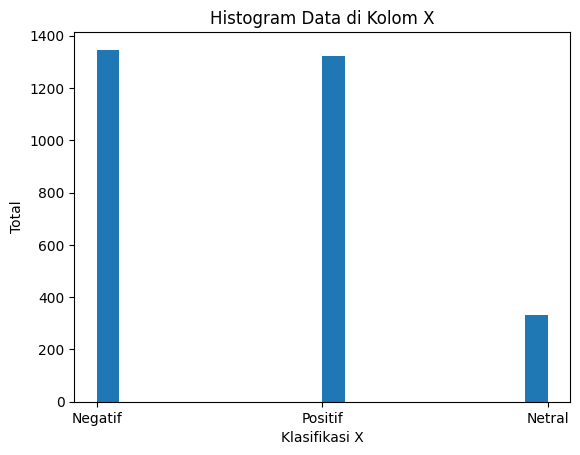

In [137]:
# Menampilkan ringkasan statistik deskriptif
data_clean.describe()

# Histogram untuk kolom
plt.hist(data_clean['Klasifikasi'], bins=20)
plt.xlabel('Klasifikasi X')
plt.ylabel('Total')
plt.title('Histogram Data di Kolom X')
plt.show()

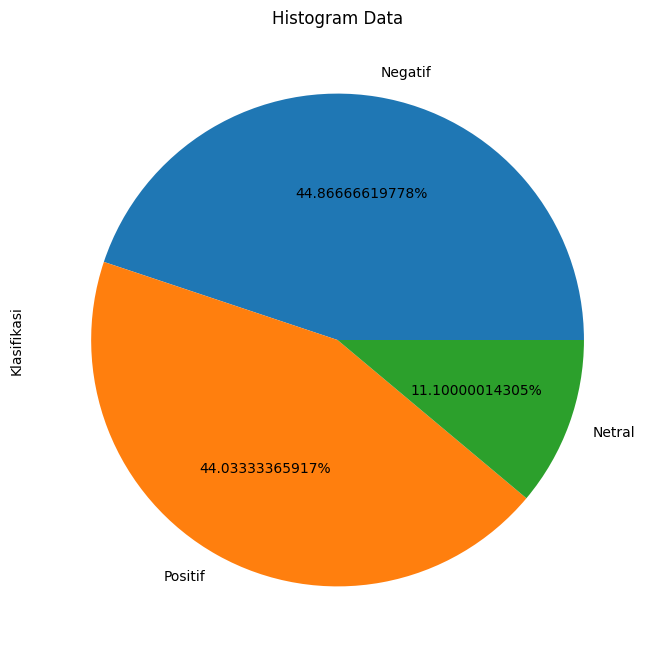

In [136]:
# Pie chart untuk kolom tertentu
plt.figure(figsize=(8, 8))
data_clean['Klasifikasi'].value_counts().plot.pie(autopct='%1.11f%%')
plt.title('Histogram Data')
plt.show()


In [106]:
# Membaca data dari file CSV
data_clean = pd.read_csv('preprocessing_result.csv')

# Menghitung jumlah masing-masing nilai dalam kolom 'Label'
jumlah_positif = data_clean['Klasifikasi'][data_clean['Klasifikasi'] == 'Positif'].count()
jumlah_negatif = data_clean['Klasifikasi'][data_clean['Klasifikasi'] == 'Negatif'].count()
jumlah_netral = data_clean['Klasifikasi'][data_clean['Klasifikasi'] == 'Netral'].count()

# Menghitung total
total = jumlah_positif + jumlah_negatif + jumlah_netral

print("Jumlah Positif:", jumlah_positif)
print("Jumlah Negatif:", jumlah_negatif)
print("Jumlah Netral:", jumlah_netral)
print("Total:", total)

Jumlah Positif: 1321
Jumlah Negatif: 1346
Jumlah Netral: 333
Total: 3000


Confusion Matrix - Naive Bayes:
[[219   0  41]
 [  0 285   0]
 [  0   0  55]]


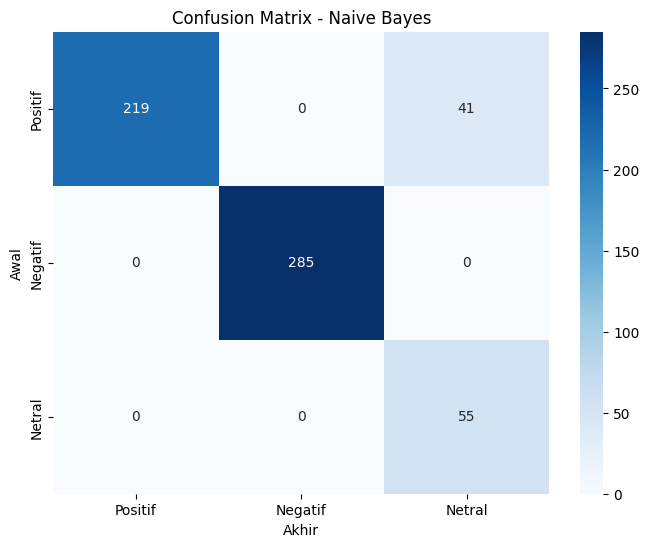

In [135]:
# Membaca data dari file CSV
data_clean = pd.read_csv('preprocessing_result.csv')

# Mengonversi nilai skor ke dalam kategori 'rendah', 'sedang', 'tinggi'
data_clean['score_category'] = pd.cut(data_clean['bintang'], bins=[-float('inf'), 2, 4, float('inf')], labels=['low', 'med', 'high'])

# Memisahkan kolom teks (fitur) dan label
X = data_clean['score_category']  # Kolom kategori skor
y = data_clean['Klasifikasi']            # Kolom label

# Membagi data menjadi data pelatihan dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menggunakan CountVectorizer untuk mengonversi kategori skor menjadi vektor fitur
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train.astype(str))  # Mengonversi ke dalam bentuk string
X_test_vectorized = vectorizer.transform(X_test.astype(str))

# Melatih model Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

# Melakukan prediksi pada data uji
prediksi = nb_classifier.predict(X_test_vectorized)

# Membuat confusion matrix
confusion = confusion_matrix(y_test, prediksi, labels=['Positif', 'Negatif', 'Netral'])

# Menampilkan confusion matrix
print("Confusion Matrix - Naive Bayes:")
print(confusion)

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Positif', 'Negatif', 'Netral'],
            yticklabels=['Positif', 'Negatif', 'Netral'])
plt.xlabel('Akhir')
plt.ylabel('Awal')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


In [133]:
# Data hasil prediksi dan label asli
data_hasil_prediksi = pd.DataFrame({
    'Awalan': y_test,  # Label asli dari data uji
    'Akhir': prediksi  # Hasil prediksi model
})

# Membuat kolom 'Prediksi_Benar' untuk menandai prediksi yang benar/salah
data_hasil_prediksi['Prediksi_Benar'] = data_hasil_prediksi['Awalan'] == data_hasil_prediksi['Akhir']

# Filter prediksi yang salah
prediksi_salah = data_hasil_prediksi[data_hasil_prediksi['Prediksi_Benar'] == True]

# Menampilkan data prediksi yang salah
print("Prediksi yang Salah:")
print(prediksi_salah)


Prediksi yang Salah:
       Awalan    Akhir  Prediksi_Benar
1801  Positif  Positif            True
1190  Positif  Positif            True
1817  Negatif  Negatif            True
251   Positif  Positif            True
2505  Negatif  Negatif            True
...       ...      ...             ...
104   Negatif  Negatif            True
2087  Negatif  Negatif            True
599    Netral   Netral            True
1756  Positif  Positif            True
1323  Positif  Positif            True

[559 rows x 3 columns]


In [162]:
# Menggabungkan data uji dengan prediksi
hasil_prediksi = pd.DataFrame({'Awalan': y_test, 'Akhir': prediksi})

# Menyaring hasil prediksi berdasarkan kriteria tertentu
prediksi_salah = hasil_prediksi[hasil_prediksi['Awalan'] != hasil_prediksi['Akhir']]

# Analisis Pola Kesalahan
print("Hasil: ", len(hasil_prediksi))
print("     : ", len(prediksi_salah))

print("Kesalahan prediksi: {:.2f}%".format((len(prediksi_salah) / len(hasil_prediksi)) * 100))

# Analisis Kata-Kata yang Paling Umum pada Data yang Salah Diprediksi
print("\nKata yang Salah Diprediksi:")
kata_salah = ' '.join(prediksi_salah['Awalan']).split()
frekuensi_kata_salah = pd.Series(kata_salah).value_counts()
print(frekuensi_kata_salah.head())

Hasil:  600
     :  41
Kesalahan prediksi: 6.83%

Kata yang Salah Diprediksi:
Positif    41
dtype: int64
